# **House Sale Price Predictor**

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot





---

## Install basic requirements

In [ ]:
%pip install -r ../requirements.txt

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2'

## Load House Price Data

We will load the house prices dataset and check for any missing values in the variables, addressing them as necessary in the upcoming sections.

In [45]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv") 

# Print the shape of the dataset
print("Shape of the dataset:", df.shape)
print("First 3 rows of the dataset:")
print(df.head(3))

# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

Shape of the dataset: (1460, 24)
First 3 rows of the dataset:
   1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuil

Split the DATA

In [3]:
from sklearn.model_selection import train_test_split

# Drop the columns explicitly, ignoring errors if they are not present
df_cleaned = df.drop(['EnclosedPorch', 'WoodDeckSF'], axis=1, errors='ignore')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop(['SalePrice'], axis=1),
    df_cleaned['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Create Pipeline

In [4]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea', 'TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])
    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Define Hyperparameter Class

In [5]:
from sklearn.model_selection import GridSearchCV

# class HyperparameterOptimizationSearch:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

 Initial Grid Search

In [ ]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)
best_model = grid_search_summary.iloc[0, 0]
print("Best model:", best_model)


Step 7: Detailed Hyperparameter Optimization

In [7]:
# Define the model for hyperparameter tuning
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# Define the hyperparameters to search for the best model
params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05, 0.1],
        'model__n_estimators': [100, 150],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_leaf_nodes': [None, 10],
    }
}

# Initialize the hyperparameter optimization search
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)

# Fit the model on the training data
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

# Get the summary of the grid search results
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

# Identify the best model and its parameters
best_model = grid_search_summary.iloc[0, 0]
best_parameters = grid_search_pipelines[best_model].best_params_
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

print("Best model:", best_model)
print("Best parameters:", best_parameters)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

                    estimator min_score mean_score max_score std_score  \
26  GradientBoostingRegressor  0.697341   0.790033  0.834748   0.04904   
27  GradientBoostingRegressor  0.682118    0.78922   0.83656  0.055026   
18  GradientBoostingRegressor  0.701413   0.787974  0.821766  0.045478   
25  GradientBoostingRegressor  0.679261   0.787526  0.834663  0.055848   
24  GradientBoostingRegressor  0.693776   0.787453  0.834236  0.049893   
..                        ...       ...        ...       ...       ...   
47  GradientBoostingRegressor  0.656072   0.759595  0.832755  0.060933   
37  GradientBoostingRegressor  0.663217   0.759577  0.834325   0.06033   
44  GradientBoostingRegressor  0.654649   0.759572  0.837211  0.063188   
45  GradientBoostingRegressor  0.661735   0.759464   0.83451  0.060829   
36  GradientBoostingRegressor  0.654598   0.759463  0.837055  0.063196   

   model__learning_rate model__max_depth model__max_leaf_nodes  \
26                 0.05                5     

Evaluate Model Performance

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Model Evaluation 

* Train Set
R2 Score: 0.901
Mean Absolute Error: 18036.814
Mean Squared Error: 608487525.518
Root Mean Squared Error: 24667.54


* Test Set
R2 Score: 0.841
Mean Absolute Error: 22126.012
Mean Squared Error: 1098321674.306
Root Mean Squared Error: 33140.937




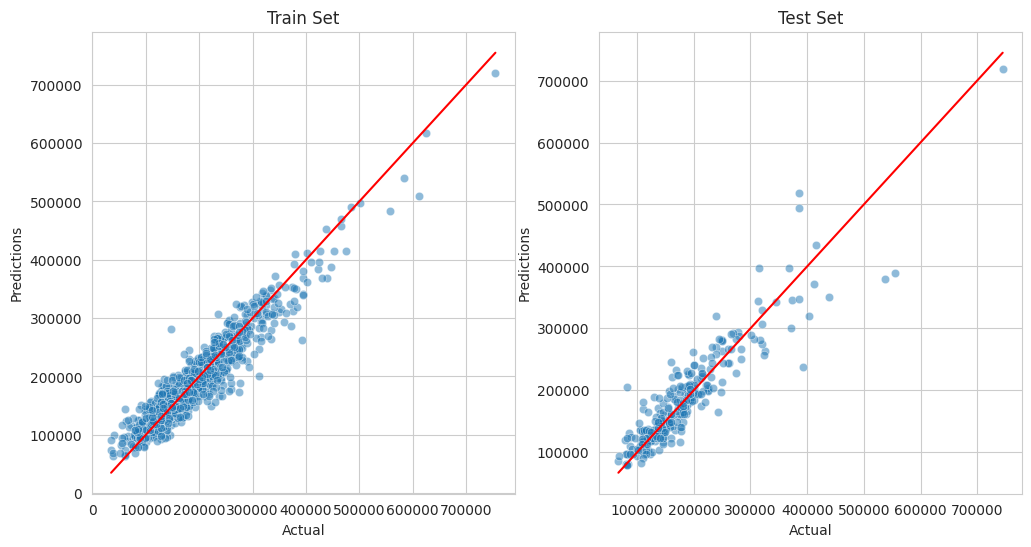

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Best parameters from the grid search
best_parameters = {
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__max_leaf_nodes': 10,
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 100
}

# Create the best regressor pipeline
best_regressor_pipeline = PipelineOptimization(GradientBoostingRegressor(random_state=0, **{
    k.split('__')[1]: v for k, v in best_parameters.items()
}))

# Fit the best model
best_regressor_pipeline.fit(X_train, y_train)

# Function to evaluate regression performance
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

# Evaluate the model performance
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Assess feature importance

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


After step: ArbitraryNumberImputer
Shape: (1168, 21)
Columns: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish',
       'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage',
       'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')
After step: CategoricalImputer
Shape: (1168, 21)
Columns: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish',
       'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage',
       'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')
After step: MedianImputation
Shape: (1168, 21)
Columns: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtU

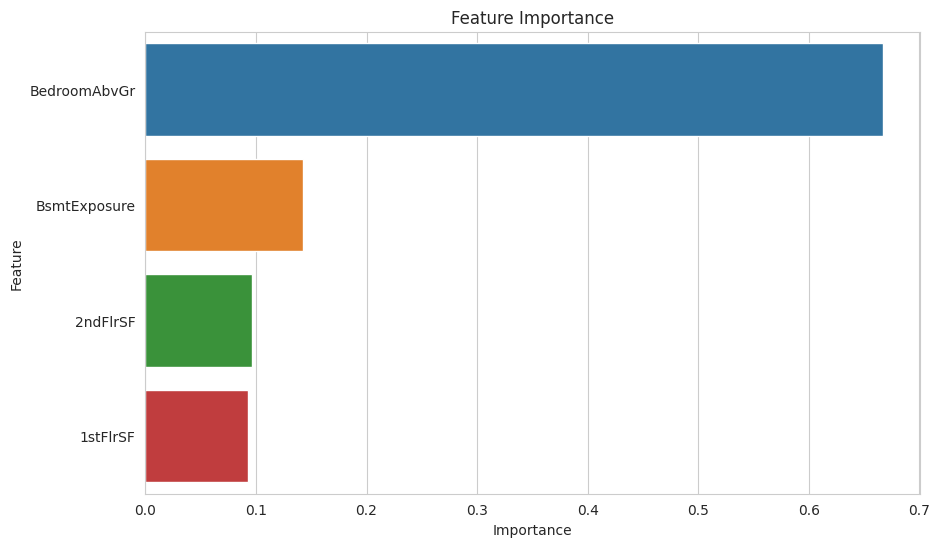

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

# Fit the pipeline on the training data
best_regressor_pipeline.fit(X_train, y_train)

# Apply all steps except the model to get the transformed features
steps = best_regressor_pipeline.named_steps

# Apply each step except the model and keep track of the feature names and shapes
X_transformed = X_train.copy()
for step_name, transformer in list(steps.items())[:-1]:  # Exclude the final model
    X_transformed = transformer.transform(X_transformed)
    print(f"After step: {step_name}")
    print(f"Shape: {X_transformed.shape}")
    if hasattr(X_transformed, 'columns'):
        print(f"Columns: {X_transformed.columns}")
    else:
        print(f"Columns: {X_train.columns[:X_transformed.shape[1]]}")

# Ensure transformed feature names are captured correctly after SmartCorrelatedSelection
if isinstance(X_transformed, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_transformed.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns[:X_transformed.shape[1]]

# Print debug information
print("Number of columns after data cleaning and feature engineering:", len(columns_after_data_cleaning_feat_eng))
print("Columns after data cleaning and feature engineering:", columns_after_data_cleaning_feat_eng)
print("Shape of transformed data:", X_transformed.shape)

# Get feature importances directly from the model
feature_importances = best_regressor_pipeline.named_steps['model'].feature_importances_

# Ensure the number of importances match the number of features
if len(columns_after_data_cleaning_feat_eng) != len(feature_importances):
    raise ValueError("The lengths of transformed feature names and feature importances do not match.")

# Create DataFrame to display feature importance
df_feature_importance = pd.DataFrame({
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Most important features statement and plot
print(f"* These are the {len(columns_after_data_cleaning_feat_eng)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].tolist()}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importance)
plt.title('Feature Importance')
plt.show()



---

# Create Machine Learning Pipeline
* The pipeline will be of type regression.

## Import libraries

In [28]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [56]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Perform imputation methods on the DataFrame
df_imputed = df.copy()

# Impute missing values for numerical variables
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df_imputed = imputer_num.fit_transform(df_imputed)

# Impute missing values for categorical variables
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df_imputed = imputer_cat.fit_transform(df_imputed)

# Impute missing values for specific variables with an arbitrary number
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'EnclosedPorch', 'WoodDeckSF'])
df_imputed = imputer_arbitrary.fit_transform(df_imputed)

# Check if there are any remaining missing values
print("Remaining missing values after imputation:")
print(df_imputed.isnull().sum().sum())

# Split the data
from sklearn.model_selection import train_test_split

X = df_imputed.drop(['SalePrice'], axis=1)
y = df_imputed['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)



Remaining missing values after imputation:
0
* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Create Pipeline Model

In [67]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

## Optimize Hyperparameter - GridSearchCV

In [74]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Data Test Set

In [75]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df_imputed.drop(['SalePrice'], axis=1),
    df_imputed['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

# Check for missing values in X_train
missing_values = X_train.isnull().sum()
variables_with_missing_values = missing_values[missing_values > 0]
print("Variables with missing values in X_train after splitting:")
print(variables_with_missing_values)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)
Variables with missing values in X_train after splitting:
Series([], dtype: int64)


# Verify no missing values in the Train Data Set

In [76]:
# Check for missing values in X_train
missing_values = X_train.isnull().sum()

# Filter variables with missing values
variables_with_missing_values = missing_values[missing_values > 0]

# Print variables with missing values
print("Variables with missing values:")
print(variables_with_missing_values)

Variables with missing values:
Series([], dtype: int64)


## Cross Validate Grid Search - Sklearn 
* Identify most suitable algorithm using default hyperparameters

In [77]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

## Present the result of the grid search cross-validation

In [78]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [79]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.773052,0.833795,0.067359
2,RandomForestRegressor,0.61857,0.75289,0.821982,0.070103
3,ExtraTreesRegressor,0.610624,0.747463,0.792766,0.069215
0,LinearRegression,0.683862,0.741346,0.838822,0.052783
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.664698,0.733887,0.088384
1,DecisionTreeRegressor,0.352237,0.520171,0.646729,0.107578


In [80]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [81]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

In [82]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

best_model = grid_search_summary.iloc[0, 0]
best_model


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

'GradientBoostingRegressor'

## Detail search for suitable hyperparameters

We identified the GradientBoostingRegressor as the most suitable model in the previous section.

In [46]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05, 0.1],
        'model__n_estimators': [100, 150],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_leaf_nodes': [None, 10],
    }
}



## Display the results of the extensive search for hyperparameters

In [48]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

# Adjust display settings to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the grid search summary
grid_search_summary


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,GradientBoostingRegressor,0.697341,0.790033,0.834748,0.04904,0.05,5,10,1,5,100
27,GradientBoostingRegressor,0.682118,0.78922,0.83656,0.055026,0.05,5,10,1,5,150
18,GradientBoostingRegressor,0.701413,0.787974,0.821766,0.045478,0.05,5,None,1,5,100
25,GradientBoostingRegressor,0.679261,0.787526,0.834663,0.055848,0.05,5,10,1,2,150
24,GradientBoostingRegressor,0.693776,0.787453,0.834236,0.049893,0.05,5,10,1,2,100
56,GradientBoostingRegressor,0.678866,0.787421,0.839036,0.056011,0.1,5,10,1,2,100
58,GradientBoostingRegressor,0.682846,0.78693,0.837237,0.054666,0.1,5,10,1,5,100
19,GradientBoostingRegressor,0.695563,0.785608,0.82141,0.04659,0.05,5,None,1,5,150
10,GradientBoostingRegressor,0.700205,0.784892,0.82937,0.047345,0.05,3,10,1,5,100
2,GradientBoostingRegressor,0.700486,0.784874,0.829348,0.047213,0.05,3,None,1,5,100


In [91]:
best_model = grid_search_summary.iloc[0, 0]
best_model

best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


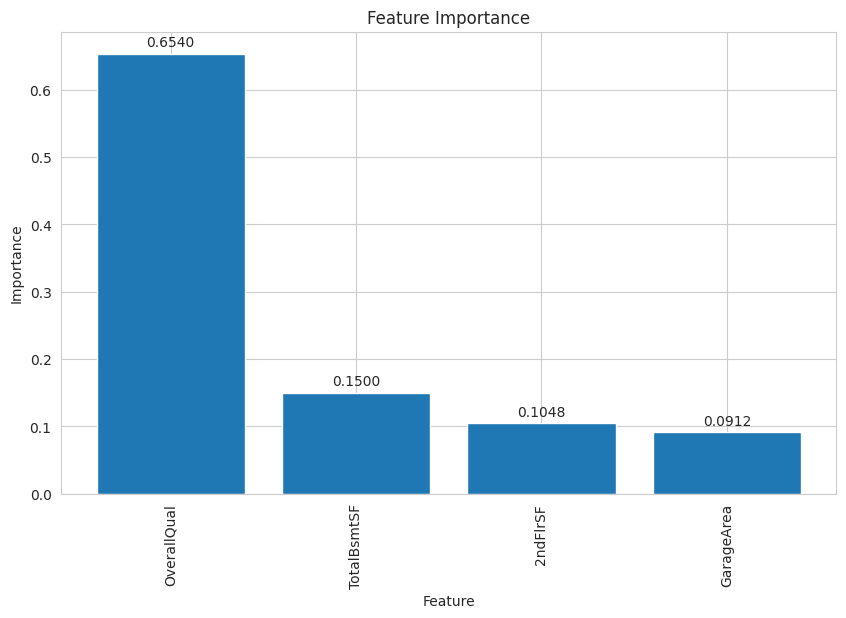

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline

# Assuming the necessary variables are already defined
data_cleaning_feat_eng_steps = 10 

# Transform X_train and get columns
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# Get the best features
best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()
].to_list()

# Create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot the feature importance with values displayed on the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_feature_importance['Feature'], df_feature_importance['Importance'])

# Add values on the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

## Evaluate Train and Test Data Sets

In [100]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

## Display performance and evalutation plots for the regressor model

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19137.251
Mean Squared Error: 699331013.628
Root Mean Squared Error: 26444.867


* Test Set
R2 Score: 0.84
Mean Absolute Error: 22239.394
Mean Squared Error: 1107161898.508
Root Mean Squared Error: 33274.042




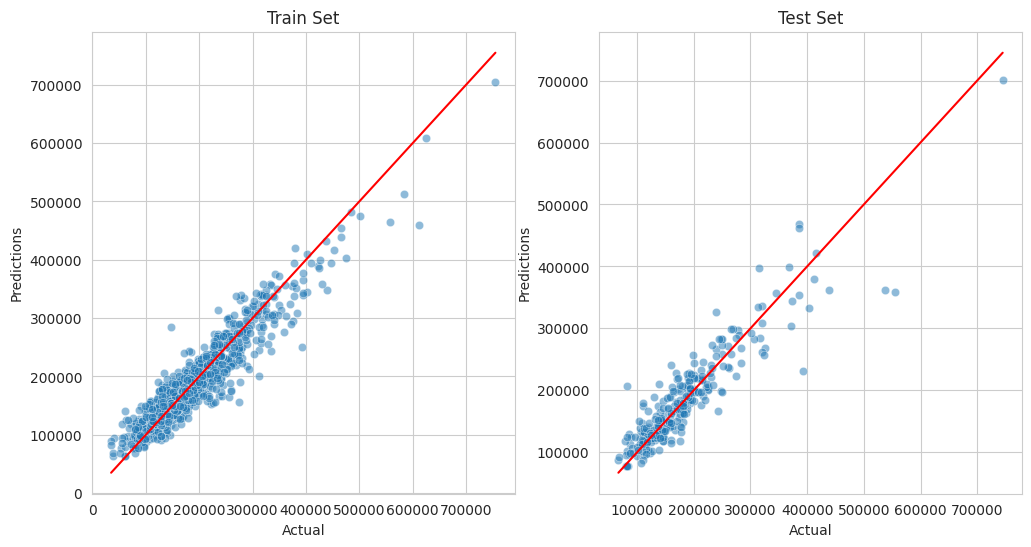

In [101]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Summary evaluation test adn feature importance
We observed a high R² score, indicating strong model performance. However, the feature "overallQual" appears to be significantly more dominant than the other features. To ensure that our model is not overly dependent on this single feature, we will conduct a permutation importance test. This test will help us validate the significance of all features and confirm that the model's performance is robust and not disproportionately influenced by "overallQual."

---

# Permutation Importance Test

In [109]:
print(type(best_model))

<class 'str'>


In [5]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Perform imputation methods on the DataFrame
df_imputed = df.copy()

# Impute missing values for numerical variables
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df_imputed = imputer_num.fit_transform(df_imputed)

# Impute missing values for categorical variables
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df_imputed = imputer_cat.fit_transform(df_imputed)

# Impute missing values for specific variables with an arbitrary number
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'EnclosedPorch', 'WoodDeckSF'])
df_imputed = imputer_arbitrary.fit_transform(df_imputed)

# Check if there are any remaining missing values
print("Remaining missing values after imputation:")
print(df_imputed.isnull().sum().sum())

# Split the data
from sklearn.model_selection import train_test_split

X = df_imputed.drop(['SalePrice'], axis=1)
y = df_imputed['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

# Define your models and parameter search
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
          'model__learning_rate': [0.05],
    }
}

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# Execute the search
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

# Get the best model pipeline
best_model_name = grid_search_summary.iloc[0, 0]
best_model_pipeline = grid_search_pipelines[best_model_name].best_estimator_

# Check pipeline steps
print("Pipeline steps:", best_model_pipeline.named_steps)

# Extract the regressor from the pipeline
best_model = best_model_pipeline.named_steps['model']

# Ensure X_test is transformed in the same way as the training data
X_test_transformed = Pipeline(best_model_pipeline.steps[:-1]).transform(X_test)

# Transform the training data using the pipeline to get the final feature set
X_train_transformed = Pipeline(best_model_pipeline.steps[:-1]).transform(X_train)

# Ensure columns_after_data_cleaning_feat_eng corresponds to the features in X_train_transformed
columns_after_transformation = X_train_transformed.columns if hasattr(X_train_transformed, 'columns') else range(X_train_transformed.shape[1])

# Calculate permutation importances and ensure sorted_idx is within bounds of columns_after_transformation
perm_importance = permutation_importance(best_model, X_test_transformed, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

# Check lengths
num_features = len(columns_after_transformation)
sorted_idx = sorted_idx[-num_features:]

# Align feature labels with sorted permutation importances
valid_feature_labels = np.array(columns_after_transformation)[sorted_idx]

# Plot the permutation importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=valid_feature_labels)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Remaining missing values after imputation:
0
* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)

Running GridSearchCV for GradientBoostingRegressor 



NameError: name 'PipelineOptimization' is not defined

Remaining missing values after imputation:
0
* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

                   estimator min_score mean_score max_score std_score  \
0  GradientBoostingRegressor  0.692948   0.782835  0.829671  0.050437   

  model__learning_rate  
0                 0.05  
Pipeline steps: {'DropFeatures': DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']), 'ArbitraryNumberImputer': ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea']), 'CategoricalImputer': CategoricalImputer(fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1']), 'MedianImputation': MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']), 'OrdinalCategoricalEncoder': OrdinalEncoder(encoding_method='arbitrary',
               variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
                          'KitchenQual']), 'LogTransformer': LogTransformer(variables=['1stFlrSF', 'GrLivArea']), 'YeoJohnsonTransformer': YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']), 'PowerTransformer': PowerTransform

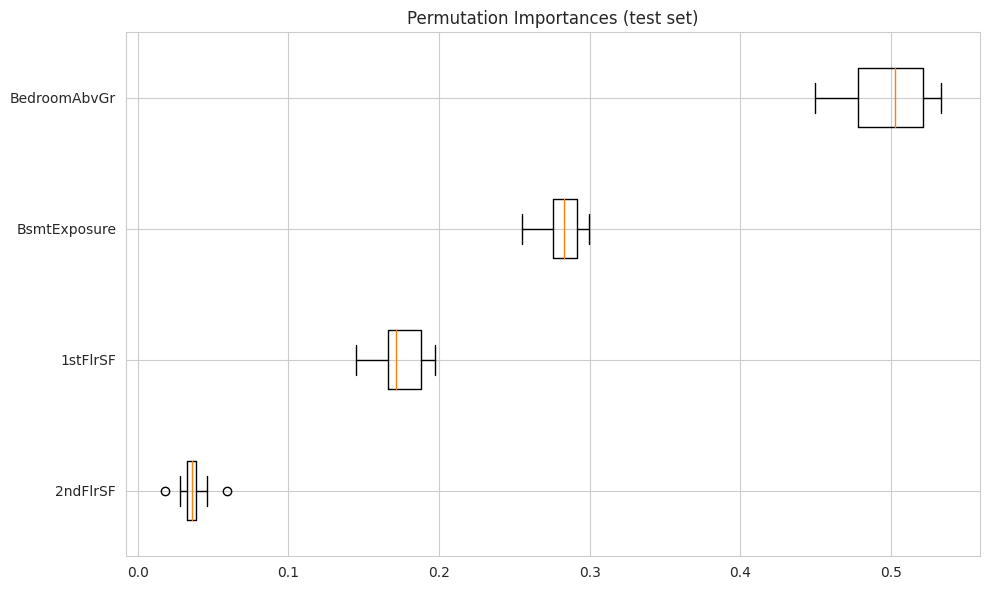

In [126]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Perform imputation methods on the DataFrame
df_imputed = df.copy()

# Impute missing values for numerical variables
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df_imputed = imputer_num.fit_transform(df_imputed)

# Impute missing values for categorical variables
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df_imputed = imputer_cat.fit_transform(df_imputed)

# Impute missing values for specific variables with an arbitrary number
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'EnclosedPorch', 'WoodDeckSF'])
df_imputed = imputer_arbitrary.fit_transform(df_imputed)

# Check if there are any remaining missing values
print("Remaining missing values after imputation:")
print(df_imputed.isnull().sum().sum())

# Split the data
from sklearn.model_selection import train_test_split

X = df_imputed.drop(['SalePrice'], axis=1)
y = df_imputed['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

# Define your models and parameter search
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
          'model__learning_rate': [0.05],
    }
}

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# Execute the search
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

# Get the best model pipeline
best_model_name = grid_search_summary.iloc[0, 0]
best_model_pipeline = grid_search_pipelines[best_model_name].best_estimator_

# Check pipeline steps
print("Pipeline steps:", best_model_pipeline.named_steps)

# Extract the regressor from the pipeline
best_model = best_model_pipeline.named_steps['model']

# Ensure X_test is transformed in the same way as the training data
X_test_transformed = Pipeline(best_model_pipeline.steps[:-1]).transform(X_test)

# Transform the training data using the pipeline to get the final feature set
X_train_transformed = Pipeline(best_model_pipeline.steps[:-1]).transform(X_train)

# Align feature labels with sorted permutation importances
perm_importance = permutation_importance(best_model, X_test_transformed, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

# Verify columns after transformation
columns_after_transformation = X_train.columns  # Get the original feature names

# Ensure sorted_idx is within bounds of columns_after_transformation
sorted_idx = sorted_idx[-len(columns_after_transformation):]

# Align feature labels
valid_feature_labels = np.array(columns_after_transformation)[sorted_idx]

# Plot the permutation importance with correct labels
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=valid_feature_labels)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()




# Try second time 

In [62]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv") 

# Print the shape of the dataset
print("Shape of the dataset:", df.shape)
print("First 3 rows of the dataset:")
print(df.head(3))

# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

Shape of the dataset: (1460, 24)
First 3 rows of the dataset:
   1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  GarageYrBlt  GrLivArea  \
0        150            0.0         548          RFn       2003.0       1710   
1        284            NaN         460          RFn       1976.0       1262   
2        434            0.0         608          RFn       2001.0       1786   

  KitchenQual  LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  \
0          Gd     8450         65.0       196.0           61            5   
1          TA     9600         80.0         0.0            0            8   
2          Gd    11250         68.0       162.0           42            5   


In [104]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Step 1: Impute missing values for numerical variables with median
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df = imputer_num.fit_transform(df)

# Step 2: Impute missing values for categorical variables with 'missing' or 'Unf'
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df = imputer_cat.fit_transform(df)

# Step 3: Impute missing values for specific variables with an arbitrary number (0 in this case)
arbitrary_vars = ['EnclosedPorch', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF']
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=arbitrary_vars)
df = imputer_arbitrary.fit_transform(df)

# Check if there are any remaining missing values in the imputed DataFrame
print("Remaining missing values after imputation:")
print(df.isnull().sum().sum())

# Check for missing data columns in the imputed DataFrame
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])



Remaining missing values after imputation:
0

Columns with missing data:
Series([], dtype: int64)


In [105]:
# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])


Columns with missing data:
Series([], dtype: int64)


In [121]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.outliers import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

# Custom transformer to add a constant to variables
class AddConstantTransformer:
    def __init__(self, variables, constant=1):
        self.variables = variables
        self.constant = constant
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.variables] = X[self.variables] + self.constant
        return X

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        # Add a constant to avoid log(0) or log(negative)
        ("AddConstant1", AddConstantTransformer(variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr'], constant=1)),
        ("AddConstant2", AddConstantTransformer(variables=['BsmtFinSF1', 'GrLivArea', 'GarageYrBlt'], constant=1)),
        ("AddConstant3", AddConstantTransformer(variables=['LotFrontage', 'MasVnrArea', 'OpenPorchSF'], constant=1)),
        ("AddConstant4", AddConstantTransformer(variables=['OverallCond', 'OverallQual', 'YearBuilt'], constant=1)),
        ("AddConstant5", AddConstantTransformer(variables=['YearRemodAdd'], constant=1)),

        # Split LogTransformers for better readability
        ("LogTransformer1", vt.LogTransformer(variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr'])),
        ("LogTransformer2", vt.LogTransformer(variables=['BsmtFinSF1', 'GrLivArea', 'GarageYrBlt'])),
        ("LogTransformer3", vt.LogTransformer(variables=['LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),
        ("LogTransformer4", vt.LogTransformer(variables=['OverallCond', 'OverallQual', 'YearBuilt'])),
        ("LogTransformer5", vt.LogTransformer(variables=['YearRemodAdd'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['GarageArea', 'TotalBsmtSF'])),
        ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'LotArea'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [123]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [125]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [126]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [127]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.64266,0.753827,0.817701,0.063347
0,LinearRegression,0.661559,0.729321,0.782108,0.049622
3,ExtraTreesRegressor,0.692457,0.728081,0.788513,0.033396
4,AdaBoostRegressor,0.626181,0.712234,0.777129,0.053877
2,RandomForestRegressor,0.618562,0.704767,0.787066,0.059354
6,XGBRegressor,0.637822,0.67607,0.711843,0.027401
1,DecisionTreeRegressor,0.352237,0.557827,0.65901,0.111804


In [128]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

---

In [129]:
# defining model parameters for a more extensive search

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05, 0.1],
        'model__n_estimators': [100, 150],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_leaf_nodes': [None, 10],
    }
}

In [130]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [131]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
18,GradientBoostingRegressor,0.700498,0.778807,0.835362,0.050035,0.05,5,None,1,5,100
19,GradientBoostingRegressor,0.694439,0.774953,0.834002,0.050705,0.05,5,None,1,5,150
26,GradientBoostingRegressor,0.697361,0.774162,0.822331,0.045483,0.05,5,10,1,5,100
2,GradientBoostingRegressor,0.699757,0.773646,0.818874,0.045625,0.05,3,None,1,5,100
10,GradientBoostingRegressor,0.699477,0.773595,0.818874,0.045725,0.05,3,10,1,5,100
8,GradientBoostingRegressor,0.692358,0.772751,0.818229,0.048844,0.05,3,10,1,2,100
0,GradientBoostingRegressor,0.692358,0.772732,0.818202,0.048833,0.05,3,None,1,2,100
50,GradientBoostingRegressor,0.684864,0.770161,0.82694,0.053226,0.1,5,None,1,5,100
24,GradientBoostingRegressor,0.69381,0.770161,0.817485,0.045186,0.05,5,10,1,2,100
58,GradientBoostingRegressor,0.682846,0.768109,0.824486,0.049823,0.1,5,10,1,5,100


In [132]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [133]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

In [134]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('MedianImputation',
                 MeanMedianIm...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCon

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Transform the data using the entire pipeline (excluding the model step)
pipeline_up_to_selection = Pipeline(best_regressor_pipeline.steps[:-1])
X_transformed = pipeline_up_to_selection.fit_transform(X_train, y_train)

# Ensure the transformed data has the expected number of columns
columns_after_data_cleaning_feat_eng = pd.DataFrame(X_transformed, columns=X_train.columns[:X_transformed.shape[1]]).columns
print(f"Columns after data cleaning and feature engineering: {len(columns_after_data_cleaning_feat_eng)}")
print(f"Column names after data cleaning and feature engineering: {columns_after_data_cleaning_feat_eng}")

# Get the support mask for the selected features from the feature selection step
support_mask = best_regressor_pipeline['feat_selection'].get_support()
print(f"Support mask length: {len(support_mask)}")
print(f"Support mask: {support_mask}")

# Verify the alignment of the support mask and columns
if len(columns_after_data_cleaning_feat_eng) != len(support_mask):
    print("Mismatch between columns and support mask lengths!")
else:
    # Extract the best features based on the support mask
    best_features = columns_after_data_cleaning_feat_eng[support_mask].tolist()
    print(f"Best features: {best_features}")

    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Feature': best_features,
        'Importance': best_regressor_pipeline['model'].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Most important features statement and plot
    print(f"* These are the {len(best_features)} most important features in descending order. "
          f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

    # Plot the feature importances
    df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
    plt.show()


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Columns after data cleaning and feature engineering: 4
Column names after data cleaning and feature engineering: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure'], dtype='object')
Support mask length: 17
Support mask: [ True False False False False False  True False False False False False
 False False  True  True False]
Mismatch between columns and support mask lengths!


In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')

# Fit and transform the data using the entire pipeline (excluding the model step)
pipeline_up_to_selection = Pipeline(best_regressor_pipeline.steps[:-1])
X_transformed = pipeline_up_to_selection.fit_transform(X_train, y_train)

# Ensure the transformed data has the expected number of columns
columns_after_data_cleaning_feat_eng = pd.DataFrame(X_transformed, columns=X_train.columns).columns
print(f"Columns after data cleaning and feature engineering: {len(columns_after_data_cleaning_feat_eng)}")
print(f"Column names after data cleaning and feature engineering: {columns_after_data_cleaning_feat_eng}")

# Get the support mask for the selected features
support_mask = best_regressor_pipeline['feat_selection'].get_support()
print(f"Support mask length: {len(support_mask)}")
print(f"Support mask: {support_mask}")

# Verify the alignment of the support mask and columns
if len(columns_after_data_cleaning_feat_eng) != len(support_mask):
    print("Mismatch between columns and support mask lengths!")

# Extract the best features based on the support mask
best_features = columns_after_data_cleaning_feat_eng[support_mask].to_list()
print(f"Best features: {best_features}")

# Create DataFrame to display feature importance
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Importance': best_regressor_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot the feature importances
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


ValueError: Shape of passed values is (1168, 4), indices imply (1168, 23)

In [137]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.936
Mean Absolute Error: 14910.234
Mean Squared Error: 393242456.083
Root Mean Squared Error: 19830.342


* Test Set
R2 Score: 0.821
Mean Absolute Error: 23328.958
Mean Squared Error: 1238761031.483
Root Mean Squared Error: 35196.037




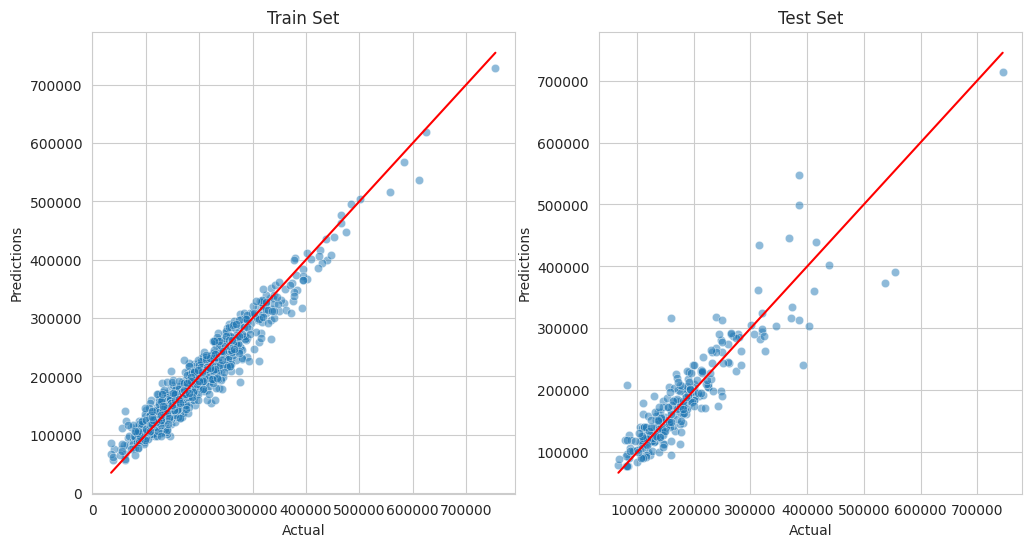

In [138]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In the previous regression, we noticed promising results concerning the R² score for both the training and test datasets. The trendline follows the data cluster without any indication of overfitting. However, we want to test if PCA will generate results with even higher confidence.

---

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv") 

# Print the shape of the dataset
print("Shape of the dataset:", df.shape)
print("First 3 rows of the dataset:")
print(df.head(3))

# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

In [153]:
import pandas as pd
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Step 1: Impute missing values for numerical variables with median
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df = imputer_num.fit_transform(df)

# Step 2: Impute missing values for categorical variables with 'missing' or 'Unf'
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df = imputer_cat.fit_transform(df)

# Step 3: Impute missing values for specific variables with an arbitrary number (0 in this case)
arbitrary_vars = ['EnclosedPorch', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF']
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=arbitrary_vars)
df = imputer_arbitrary.fit_transform(df)

# Check if there are any remaining missing values in the imputed DataFrame
print("Remaining missing values after imputation:")
print(df.isnull().sum().sum())

# Check for missing data columns in the imputed DataFrame
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

Remaining missing values after imputation:
0

Columns with missing data:
Series([], dtype: int64)


In [155]:
# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])


Columns with missing data:
Series([], dtype: int64)


In [159]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base


In [161]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [163]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [164]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [165]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.773052,0.833795,0.067359
2,RandomForestRegressor,0.61857,0.75289,0.821982,0.070103
3,ExtraTreesRegressor,0.610624,0.747463,0.792766,0.069215
0,LinearRegression,0.683862,0.741346,0.838822,0.052783
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.664698,0.733887,0.088384
1,DecisionTreeRegressor,0.352237,0.520171,0.646729,0.107578


In [166]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [167]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
          # 'model__n_estimators': [50, 75, 100], # gives little improvements we stick to default = 100
          # 'model__max_depth': [3, 5, 10], # gives little improvement we stick to default = 3
          'model__learning_rate': [0.05], # This learning rate consistently gave the best r2 scores, default = 0.1
          # 'model__learning_rate': [0.05, 0.07, 0.1], # default = 0.1
          # 'model__min_samples_split': [2, 25, 50, 75], # setting this to 75 also gives very good results, but we will stick to the default = 2
          # 'model__min_samples_leaf': [1, 25, 50, 75], # changing this parameter also seems to cause slight overfitting - keep default = 1
          # 'model__max_leaf_nodes': [None, 25, 50, 75], # Changing this parameter seems to often cause slight overfitting - keep default = None
    }
}

In [168]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [169]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate
0,GradientBoostingRegressor,0.692948,0.782835,0.829671,0.050437,0.05


In [170]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [171]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05}

In [172]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:141: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories do not exist. Try using the RareLabelCategoricalEncoder to remove infrequent categories before calling this encoder.
  warnings.warn(


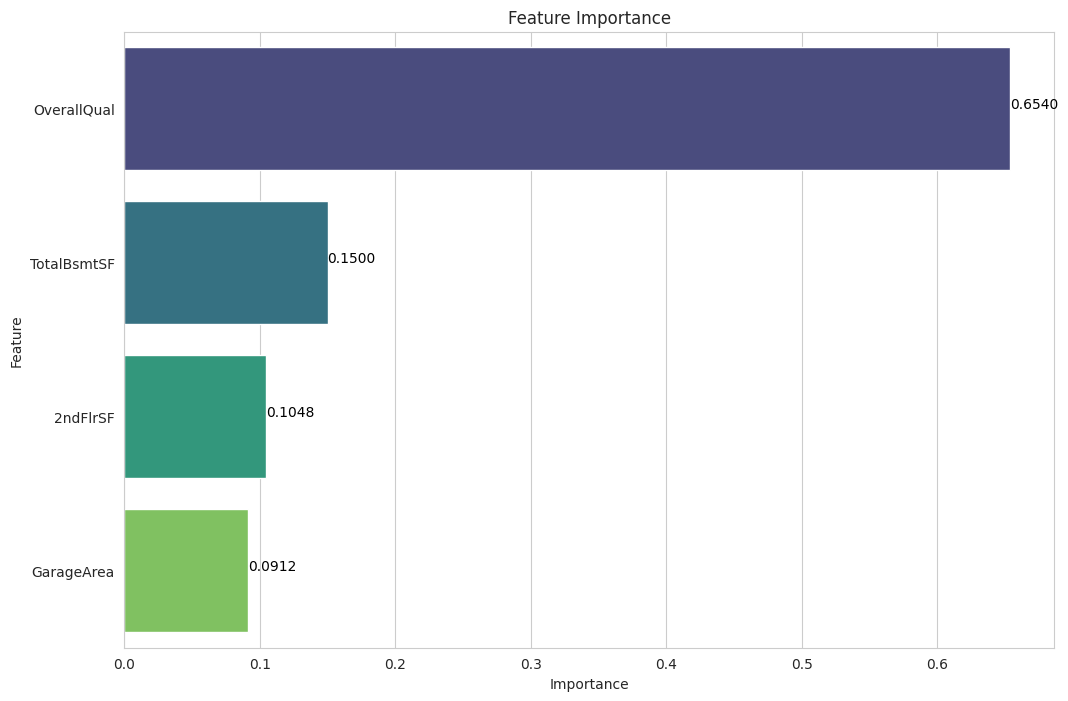

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changed
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot the feature importance with values on top of the bars
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=df_feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add values on top of the bars
for index, value in enumerate(df_feature_importance['Importance']):
    barplot.text(value, index, f'{value:.4f}', color='black', ha="left")

plt.show()

In [174]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19137.251
Mean Squared Error: 699331013.628
Root Mean Squared Error: 26444.867


* Test Set
R2 Score: 0.84
Mean Absolute Error: 22239.394
Mean Squared Error: 1107161898.508
Root Mean Squared Error: 33274.042




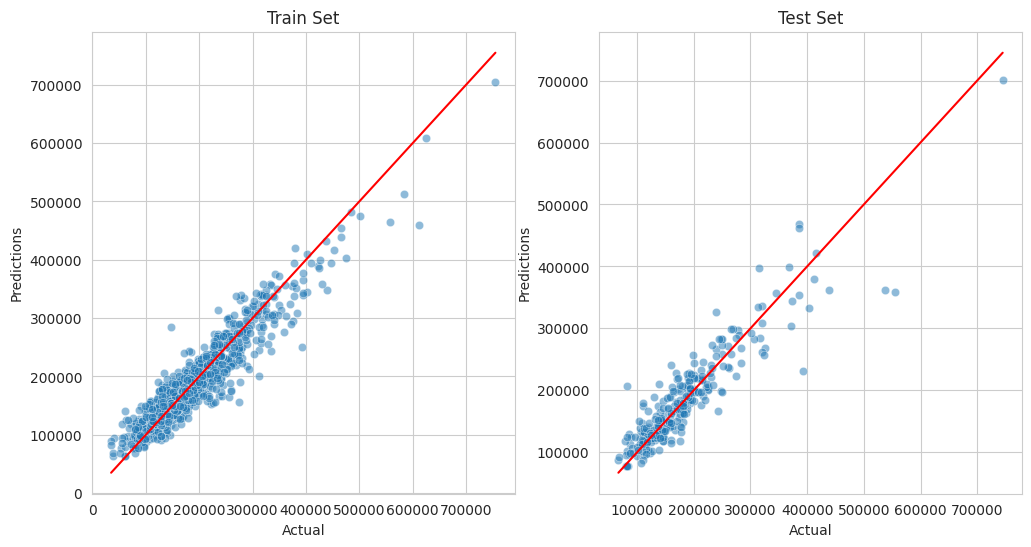

In [175]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

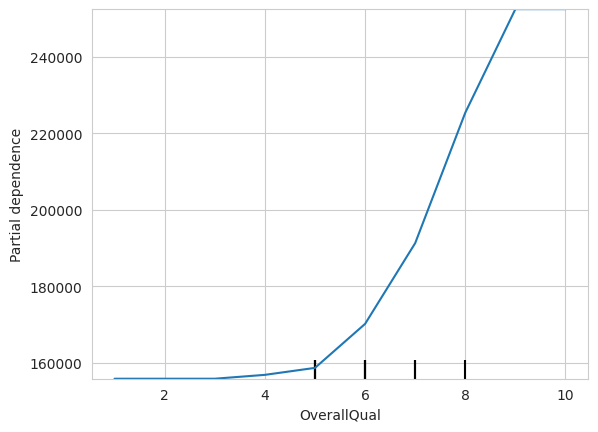

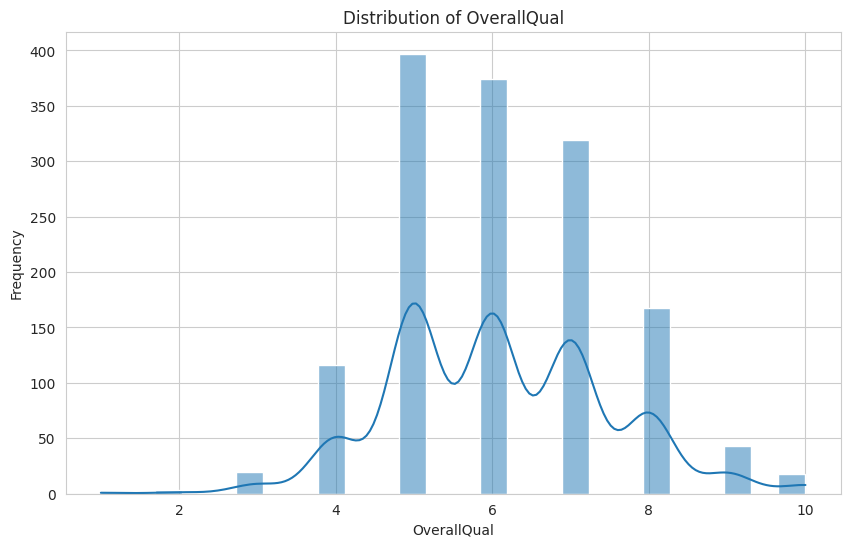

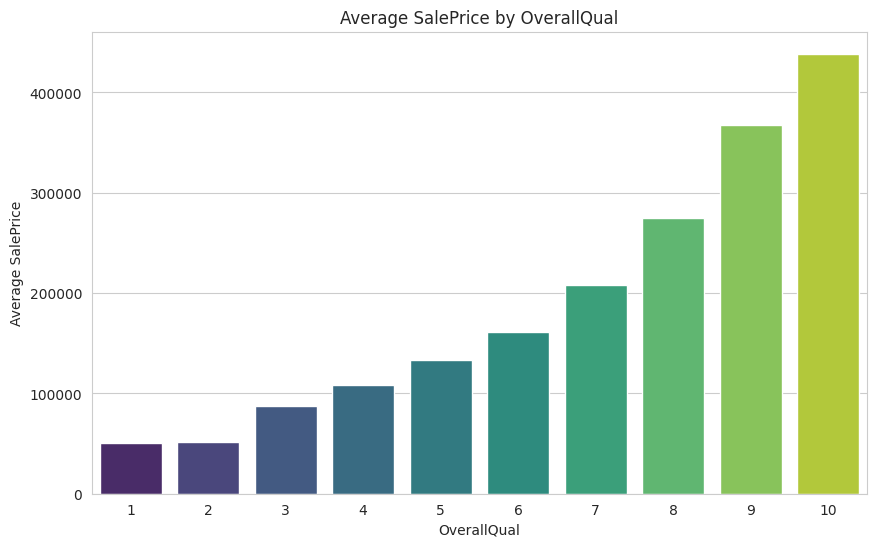

In [180]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Plot the PDP for the dominant feature 'OverallQual'
dominant_feature = 'OverallQual'  # Your dominant feature

# Plot the Partial Dependence
plot_partial_dependence(model_pipeline, X_train, [dominant_feature], grid_resolution=50)
plt.show()

# Create a distribution plot for 'OverallQual'
plt.figure(figsize=(10, 6))
sns.histplot(df['OverallQual'], kde=True)
plt.title('Distribution of OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Frequency')
plt.show()

# Calculate the average SalePrice for each OverallQual rating
overall_qual_avg_price = df.groupby('OverallQual')['SalePrice'].mean().reset_index()

# Plot the relationship between OverallQual and average SalePrice
plt.figure(figsize=(10, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=overall_qual_avg_price, palette='viridis')
plt.title('Average SalePrice by OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Average SalePrice')
plt.show()




In [181]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model with OverallQual
score_with_qual = model_pipeline.score(X_test, y_test)
print(f"Model performance with OverallQual: {score_with_qual}")

Model performance with OverallQual: 0.8946362669038835


In [182]:
# Remove the 'OverallQual' feature from the training and test sets
X_train_wo_qual = X_train.drop(columns=['OverallQual'])
X_test_wo_qual = X_test.drop(columns=['OverallQual'])

# Define a new preprocessing pipeline for the dataset without 'OverallQual'
preprocessor_wo_qual = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', [col for col in numeric_features if col != 'OverallQual']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a new model pipeline without 'OverallQual'
model_pipeline_wo_qual = Pipeline(steps=[
    ('preprocessor', preprocessor_wo_qual),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Train the new model
model_pipeline_wo_qual.fit(X_train_wo_qual, y_train)

# Evaluate the model without OverallQual
score_wo_qual = model_pipeline_wo_qual.score(X_test_wo_qual, y_test)
print(f"Model performance without OverallQual: {score_wo_qual}")

Model performance without OverallQual: 0.8933124702388011


In [185]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder

# Load your dataset
df = pd.read_csv("/workspace/heritage-housing2/outputs/datasets/collection/HousePrices.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column name
y = df['SalePrice']

# Imputation strategies
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=0, variables=['EnclosedPorch','1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'])

# Fit and transform the data
X = imputer_num.fit_transform(X)
X = imputer_cat.fit_transform(X)
X = imputer_arbitrary.fit_transform(X)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Ordinal encoding for certain categorical features
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])
X = encoder.fit_transform(X)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that first preprocesses the data then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'EnclosedPorch',
                                                   'GarageArea', 'GarageYrBlt',
                                                   'GrLivArea', 'LotArea',
                                                   'LotFrontage', 'MasVnrArea',
                                                   'OpenPorchSF', 'OverallCond',
                                                   'OverallQual', 'TotalBsmtSF',
                                                   'WoodDeckSF', 'YearBuilt',
                                                   'YearRemodAdd']),
                                                 ('cat',
                                                  OneHotE

In [186]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
perm_importance = permutation_importance(model_pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Extract importance scores and feature names
importance_scores = perm_importance.importances_mean
feature_names = X.columns

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
18    OverallQual    0.283174
11      GrLivArea    0.137477
21      YearBuilt    0.038877
1        2ndFlrSF    0.031308
19    TotalBsmtSF    0.026276
0        1stFlrSF    0.015696
13        LotArea    0.015399
12    KitchenQual    0.014532
8      GarageArea    0.014268
4      BsmtFinSF1    0.010401
17    OverallCond    0.008692
22   YearRemodAdd    0.007708
3    BsmtExposure    0.003428
16    OpenPorchSF    0.002151
14    LotFrontage    0.000514
15     MasVnrArea    0.000512
9    GarageFinish    0.000362
7   EnclosedPorch    0.000000
5    BsmtFinType1    0.000000
10    GarageYrBlt   -0.000073
2    BedroomAbvGr   -0.000221
20     WoodDeckSF   -0.000776
6       BsmtUnfSF   -0.001482


## Transform PCA Pipeline

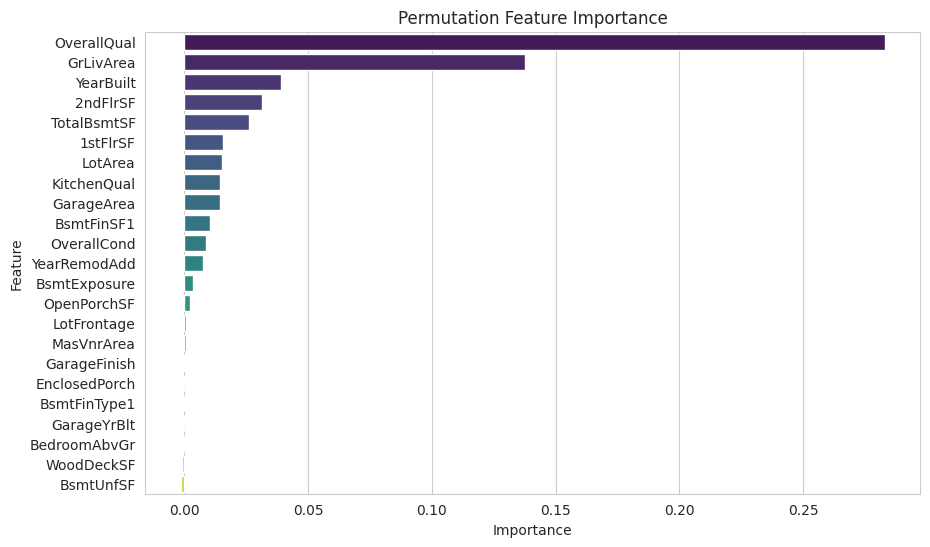

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot permutation feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:10])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

## Analyze PCA components

* The 17 components explain 100.0% of the data 



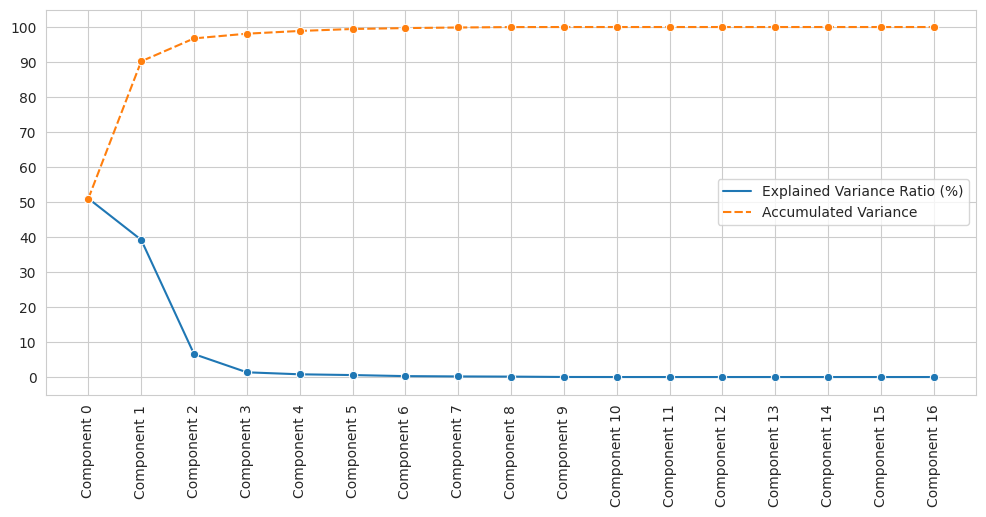

In [16]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Perform PCA for most significant components

* The 4 components explain 98.1% of the data 



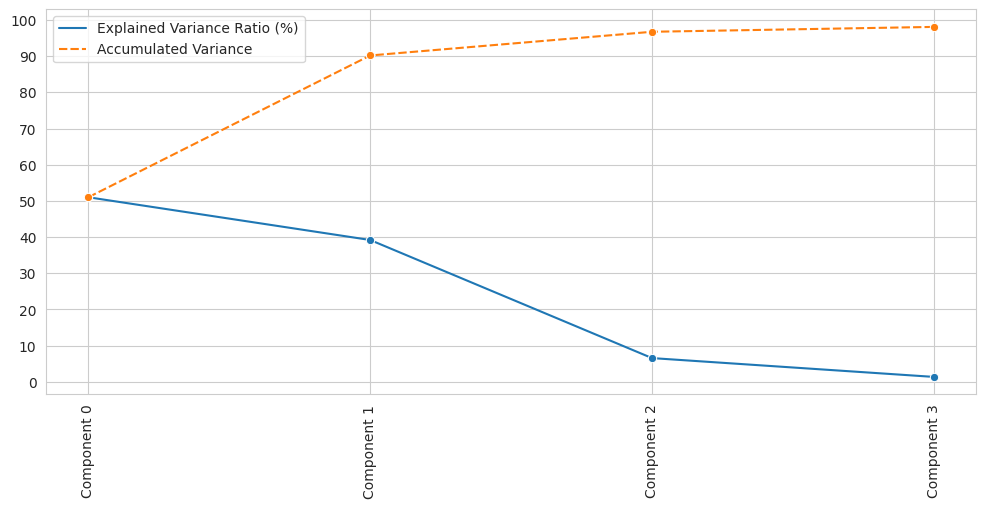

In [17]:
n_components = 4
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Preprocess data for pipeline with PCA

In [18]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

# Create the pipeline for imputation, encoding, and PCA
pipeline = Pipeline([
    # Impute missing values for numerical variables
    ("imputer_num", MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'WoodDeckSF', 'EnclosedPorch'])),
    
    # Impute missing values for categorical variables
    ("imputer_cat", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
    
    # Encode categorical variables
    ("encoder", OrdinalEncoder(encoding_method='arbitrary', 
                               variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure', 'KitchenQual'])),
    
    # Apply PCA
    ("pca", PCA(n_components=4))  # Modify n_components as needed
])

# Fit and transform the data
df_pca = pipeline.fit_transform(df.drop(['SalePrice'], axis=1))

# Check the result
print(df_pca.shape, '\n', type(df_pca))



(1460, 4) 
 <class 'numpy.ndarray'>


# Rewrite the ML Pipeline for Modelling using PCA

In [19]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Principle Component Analysis
        ("PCA", PCA(n_components=4, random_state=0)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [20]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [21]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

In [23]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.670019,0.73341,0.807928,0.044386
5,GradientBoostingRegressor,0.610125,0.728766,0.796547,0.06254
3,ExtraTreesRegressor,0.593063,0.720547,0.808578,0.070307
6,XGBRegressor,0.625331,0.708058,0.768697,0.0466
0,LinearRegression,0.640613,0.689321,0.746614,0.03518
4,AdaBoostRegressor,0.586708,0.660877,0.770249,0.062313
1,DecisionTreeRegressor,0.43524,0.544961,0.659983,0.073943


In [24]:
# defining model parameters for a more extensive search - we only test 3 parameters. It is unlikely that we will get any improvement over the 
# initial pipeline with 4 important features used.

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [20, 50, 100, 300],
        'model__max_depth': [3,5,8],
        'model__learning_rate': [0.03, 0.05, 0.07, 0.1],
    }
}

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

In [28]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
29,GradientBoostingRegressor,0.655916,0.737026,0.790031,0.044959,0.07,5,50
17,GradientBoostingRegressor,0.665,0.734936,0.7862,0.039358,0.05,5,50
6,GradientBoostingRegressor,0.649494,0.73467,0.79589,0.04758,0.03,5,100
37,GradientBoostingRegressor,0.623121,0.733292,0.800481,0.058917,0.1,3,50
30,GradientBoostingRegressor,0.64057,0.733099,0.786432,0.049323,0.07,5,100
25,GradientBoostingRegressor,0.646601,0.732501,0.803954,0.050369,0.07,3,50
18,GradientBoostingRegressor,0.650292,0.732339,0.780414,0.043604,0.05,5,100
26,GradientBoostingRegressor,0.621261,0.732013,0.805434,0.060218,0.07,3,100
14,GradientBoostingRegressor,0.620928,0.731666,0.809949,0.061408,0.05,3,100
7,GradientBoostingRegressor,0.633753,0.730426,0.7869,0.051204,0.03,5,300


## Identify and store the suitable ML Pipeline

In [26]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [27]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.05],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [None],
    }
}

Display the suitbale pipeline

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

best_model = grid_search_summary.iloc[0,0]
best_model

# Defining the best pipeline

pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [29]:
import joblib
import os

# Define the version and file path relative to the project's root directory
version = 'v14_test'
file_path = os.path.join('/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price', version)

try:
    os.makedirs(file_path, exist_ok=True)
except Exception as e:
    print(e)

## Train Set : features and target

In [30]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,3.0,Av,48,Unf,1774,0.0,774,Unf,...,11694,90.0,452.0,108,5,9,1822,0.0,2007,2007
870,894,0.0,2.0,No,0,Unf,894,0.0,308,Unf,...,6600,60.0,0.0,0,5,5,894,0.0,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,0.0,432,Unf,...,13360,80.0,0.0,0,7,5,876,0.0,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,0.0,857,RFn,...,13265,69.0,148.0,59,5,8,1568,0.0,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,0.0,843,RFn,...,13704,118.0,150.0,81,5,7,1541,0.0,2001,2002


In [31]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [36]:
y_train.head()

921     145900
520     106250
401     164990
280     228500
1401    193000
Name: SalePrice, dtype: int64

In [32]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

X_test.head()

In [33]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [34]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [35]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [36]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   'GarageArea', 'GrLivArea',
                                                   'LotArea', 'LotFrontage',
                                                   'MasVnrArea',
                                                   'OpenPorchSF'])),
                ('CategoricalImputer'...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
         

In [37]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price/v14_test/regression_pipeline.pkl']

## Feature Importance Plot 

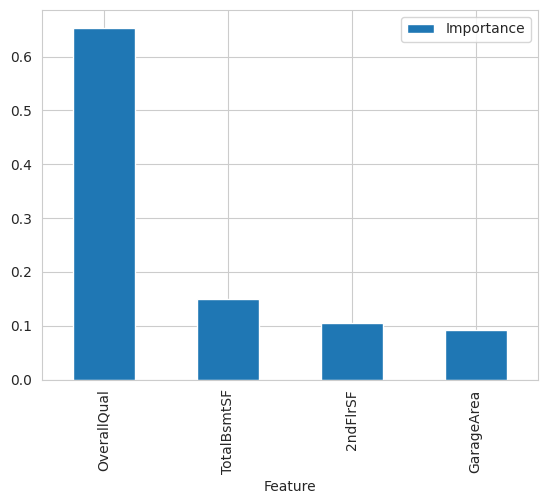

In [38]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

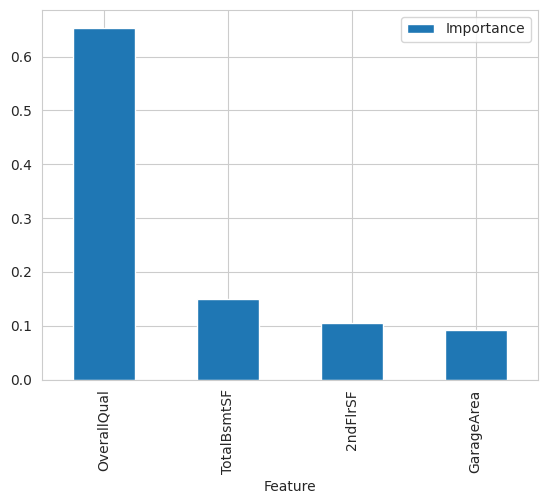

In [39]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

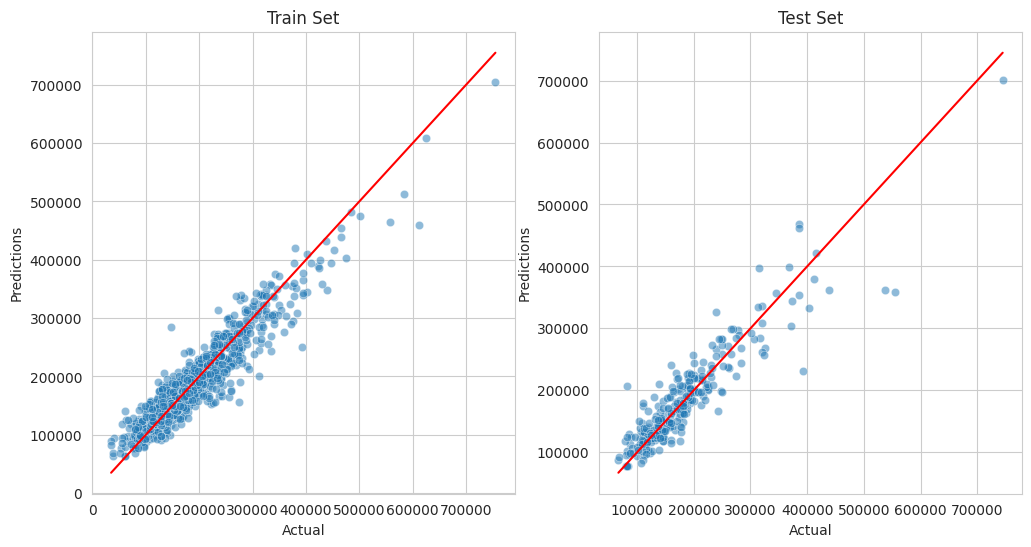

In [40]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)